imports

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
config_plots.global_settings()

parameters

In [2]:
experimentsPath="/home/elhamod/HGNN/experiments/"
dataPath="/data/BGNN_data"
experimentName="biology_paper_datasizes"

generate_confusion_matrix = False

cuda=7

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 7


Setup

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

# instantiate trial stat object
results_dir = os.path.join(experimentPathAndName, "results")
ts = TrialStatistics.TrialStatistics(results_dir)
ts_coarse = TrialStatistics.TrialStatistics(results_dir, "coarse")

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

Show and save trial statistics

In [5]:

with tqdm(total=number_of_experiments, desc="experiment") as bar:
    for experiment_params in config_parser.getExperiments():
        print(experiment_params)

        # For analyzing experiments, we don't care about augmentation
        datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        fineList = train_loader.dataset.csv_processor.getFineList()
        coarseList = train_loader.dataset.csv_processor.getCoarseList()
        architecture = {
            "fine": len(fineList),
            "coarse" : len(coarseList)
        }


        
        # Loop through n trials
        for i in trange(experiment_params["numOfTrials"], desc="trial"):
            modelName = getModelName(experiment_params, i)
            trialName = os.path.join(experimentPathAndName, modelName)
            
            # Train/Load model
            print(CNN.getModelFile(trialName))
            model = CNN.create_model(architecture, experiment_params)
            if os.path.exists(CNN.getModelFile(trialName)):
                df, epochs, time_elapsed = CNN.loadModel(model, trialName)
                
                # Update trial outcomes for statistics
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
                ts.addTrialPredictions(experiment_params, predlist, lbllist, range(len(fineList)))
                micro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params)
                topk = CNN.top_k_acc(predlist, lbllist, topk=(3,5))

                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'coarse')
                ts_coarse.addTrialPredictions(experiment_params, predlist, lbllist, range(len(coarseList)))
                micro_f1_coarse = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictions(validation_loader, model, experiment_params)
                macro_f1_val = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                score = {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                         'average correct guess prob': CNN.getAvgProbCorrectGuessFromLoader(test_loader, model, experiment_params),
                         'macro f1 test fine': micro_f1,
                         'macro f1 test coarse': micro_f1_coarse,
                         'macro f1 validation fine': macro_f1_val,
                         'time': time_elapsed,
                         'epochs': epochs,
                         'top-3': topk[0].cpu().numpy(),
                         'top-5': topk[1].cpu().numpy(),
                        }

                ts.addTrial(experiment_params,
                    score, i)
            else:
                print("Model {0} not found!".format(trialName))
        
        bar.update()
        
# Save experiment results
ts.saveStatistics()
ts.saveStatistics(False)
ts.showStatistics()
ts.showStatistics(False)

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_200max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 3, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.6, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool'}
Creating datasets...


scanning files: 100%|██████████| 6470/6470 [00:24<00:00, 262.91it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/d8f17091017210e48c95b4c05fd739e63a50eb70843b8269b1113f6c/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/57b36ab31161dba381fe06dbd9543682dbcd979328f2b73fe3e09f9a/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/07c253249b30b5df1ce9f5d2a3a42e34f082bc36097a0ce2e67183f5/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_100max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 3, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.6, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool'}
Creating datasets...


scanning files: 100%|██████████| 3762/3762 [00:15<00:00, 247.10it/s]

Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/4e5b1e3afdc38edf3ec7b623063dfc51043755e5a289592e01faf9a7/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/b889c49b0e3b28379906fc14ea576a6a1808013b27e9e7402fa878c8/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/3bc12e8076139fdaa2172c41e8f1223e9d187de667a7de270afe6a80/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_50max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 3, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.6, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool'}
Creating datasets...


scanning files: 100%|██████████| 1900/1900 [00:08<00:00, 229.86it/s]

Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/710de2ce3b48a0480d4a481a695de1c0b2b8d5a8d21c10b482bac255/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/1aa7a310491de3c0ed22afcd6fbbf0ce7654593fe16c5e9d62763864/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes/models/2f023c9d174ce312a0281280f87cadafff1b765183e2109f8c2bb022/finalModel.pt




,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,unsupervisedOnTest,tl_model,link_layer,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,INHS_cropped,biology_paper_cleaned_200max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,2.967031,0.706986,0.914554,0.987841,0.918837,26275.190812,83.0,98.377129,98.608963,d0250f20d79900d48b37d9076fd7395c8ccd7afadfed9043780cbd17,0,d8f17091017210e48c95b4c05fd739e63a50eb70843b8269b1113f6c
1,INHS_cropped,biology_paper_cleaned_200max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,2.950377,0.724119,0.930147,0.990576,0.916296,33203.778006,105.0,98.068008,98.608963,d0250f20d79900d48b37d9076fd7395c8ccd7afadfed9043780cbd17,1,57b36ab31161dba381fe06dbd9543682dbcd979328f2b73fe3e09f9a
2,INHS_cropped,biology_paper_cleaned_200max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.024960,0.647326,0.920865,0.990576,0.920847,5317.299169,30.0,98.068008,98.995361,d0250f20d79900d48b37d9076fd7395c8ccd7afadfed9043780cbd17,2,07c253249b30b5df1ce9f5d2a3a42e34f082bc36097a0ce2e67183f5
3,INHS_cropped,biology_paper_cleaned_100max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.100184,0.570466,0.901640,0.981450,0.857874,2866.669914,21.0,97.343964,98.007973,91089f1d6467c68bb5839b2253162f72a7f59aaef0ad8e0087aacffe,0,4e5b1e3afdc38edf3ec7b623063dfc51043755e5a289592e01faf9a7
4,INHS_cropped,biology_paper_cleaned_100max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.113902,0.556372,0.922293,0.986286,0.906475,2729.207628,20.0,98.140770,99.203194,91089f1d6467c68bb5839b2253162f72a7f59aaef0ad8e0087aacffe,1,b889c49b0e3b28379906fc14ea576a6a1808013b27e9e7402fa878c8
5,INHS_cropped,biology_paper_cleaned_100max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.096246,0.574459,0.906129,0.990819,0.882424,4027.030761,30.0,97.742371,98.273575,91089f1d6467c68bb5839b2253162f72a7f59aaef0ad8e0087aacffe,2,3bc12e8076139fdaa2172c41e8f1223e9d187de667a7de270afe6a80
6,INHS_cropped,biology_paper_cleaned_50max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.243850,0.424087,0.858355,0.972760,0.837166,3305.285958,33.0,95.526321,96.052635,e6a66635555bc1eb38ec09fe1752fa0b94da37f56227eb354bf4d077,0,710de2ce3b48a0480d4a481a695de1c0b2b8d5a8d21c10b482bac255
7,INHS_cropped,biology_paper_cleaned_50max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.246876,0.421074,0.829184,0.962199,0.835752,3231.806586,33.0,96.052635,97.368423,e6a66635555bc1eb38ec09fe1752fa0b94da37f56227eb354bf4d077,1,1aa7a310491de3c0ed22afcd6fbbf0ce7654593fe16c5e9d62763864
8,INHS_cropped,biology_paper_cleaned_50max,448,True,64,0.00005,3,1,HGNN_add,0.6,False,ResNet18,avgpool,3.252556,0.415396,0.825587,0.881341,0.816879,2300.739032,24.0,94.473686,96.578949,e6a66635555bc1eb38ec09fe1752fa0b94da37f56227eb354bf4d077,2,2f023c9d174ce312a0281280f87cadafff1b765183e2109f8c2bb022


Show and save confusion matrix

In [6]:
if generate_confusion_matrix:
    with tqdm(total=number_of_experiments, desc="experiment") as bar:
        for experiment_params in config_parser.getExperiments():
            print(experiment_params)

            ts.printTrialConfusionMatrix(experiment_params, fineList , printOutput=True)
            ts_coarse.printTrialConfusionMatrix(experiment_params,  coarseList, printOutput=True)

            bar.update()

Print scatter plot

In [7]:
# ts.df = ts.df.replace(r"_", "", regex=True)
# ts.df = ts.df.rename(columns={"link_layer": "linkLayer"})
# ts.trialScatter('macro f1 test fine', 'epochs', 'suffix', True)
# ts.pandasBoxplot(['macro f1 test coarse'], ['epochs'])

In [8]:
# ts.trialScatter('macro f1 test fine', 'time', 'learning_rate', True)

In [9]:
# ts.pandasBoxplot(['macro f1 test fine'], ['suffix'])
# ts.pandasBoxplot(['macro f1 test coarse'], ['suffix'])

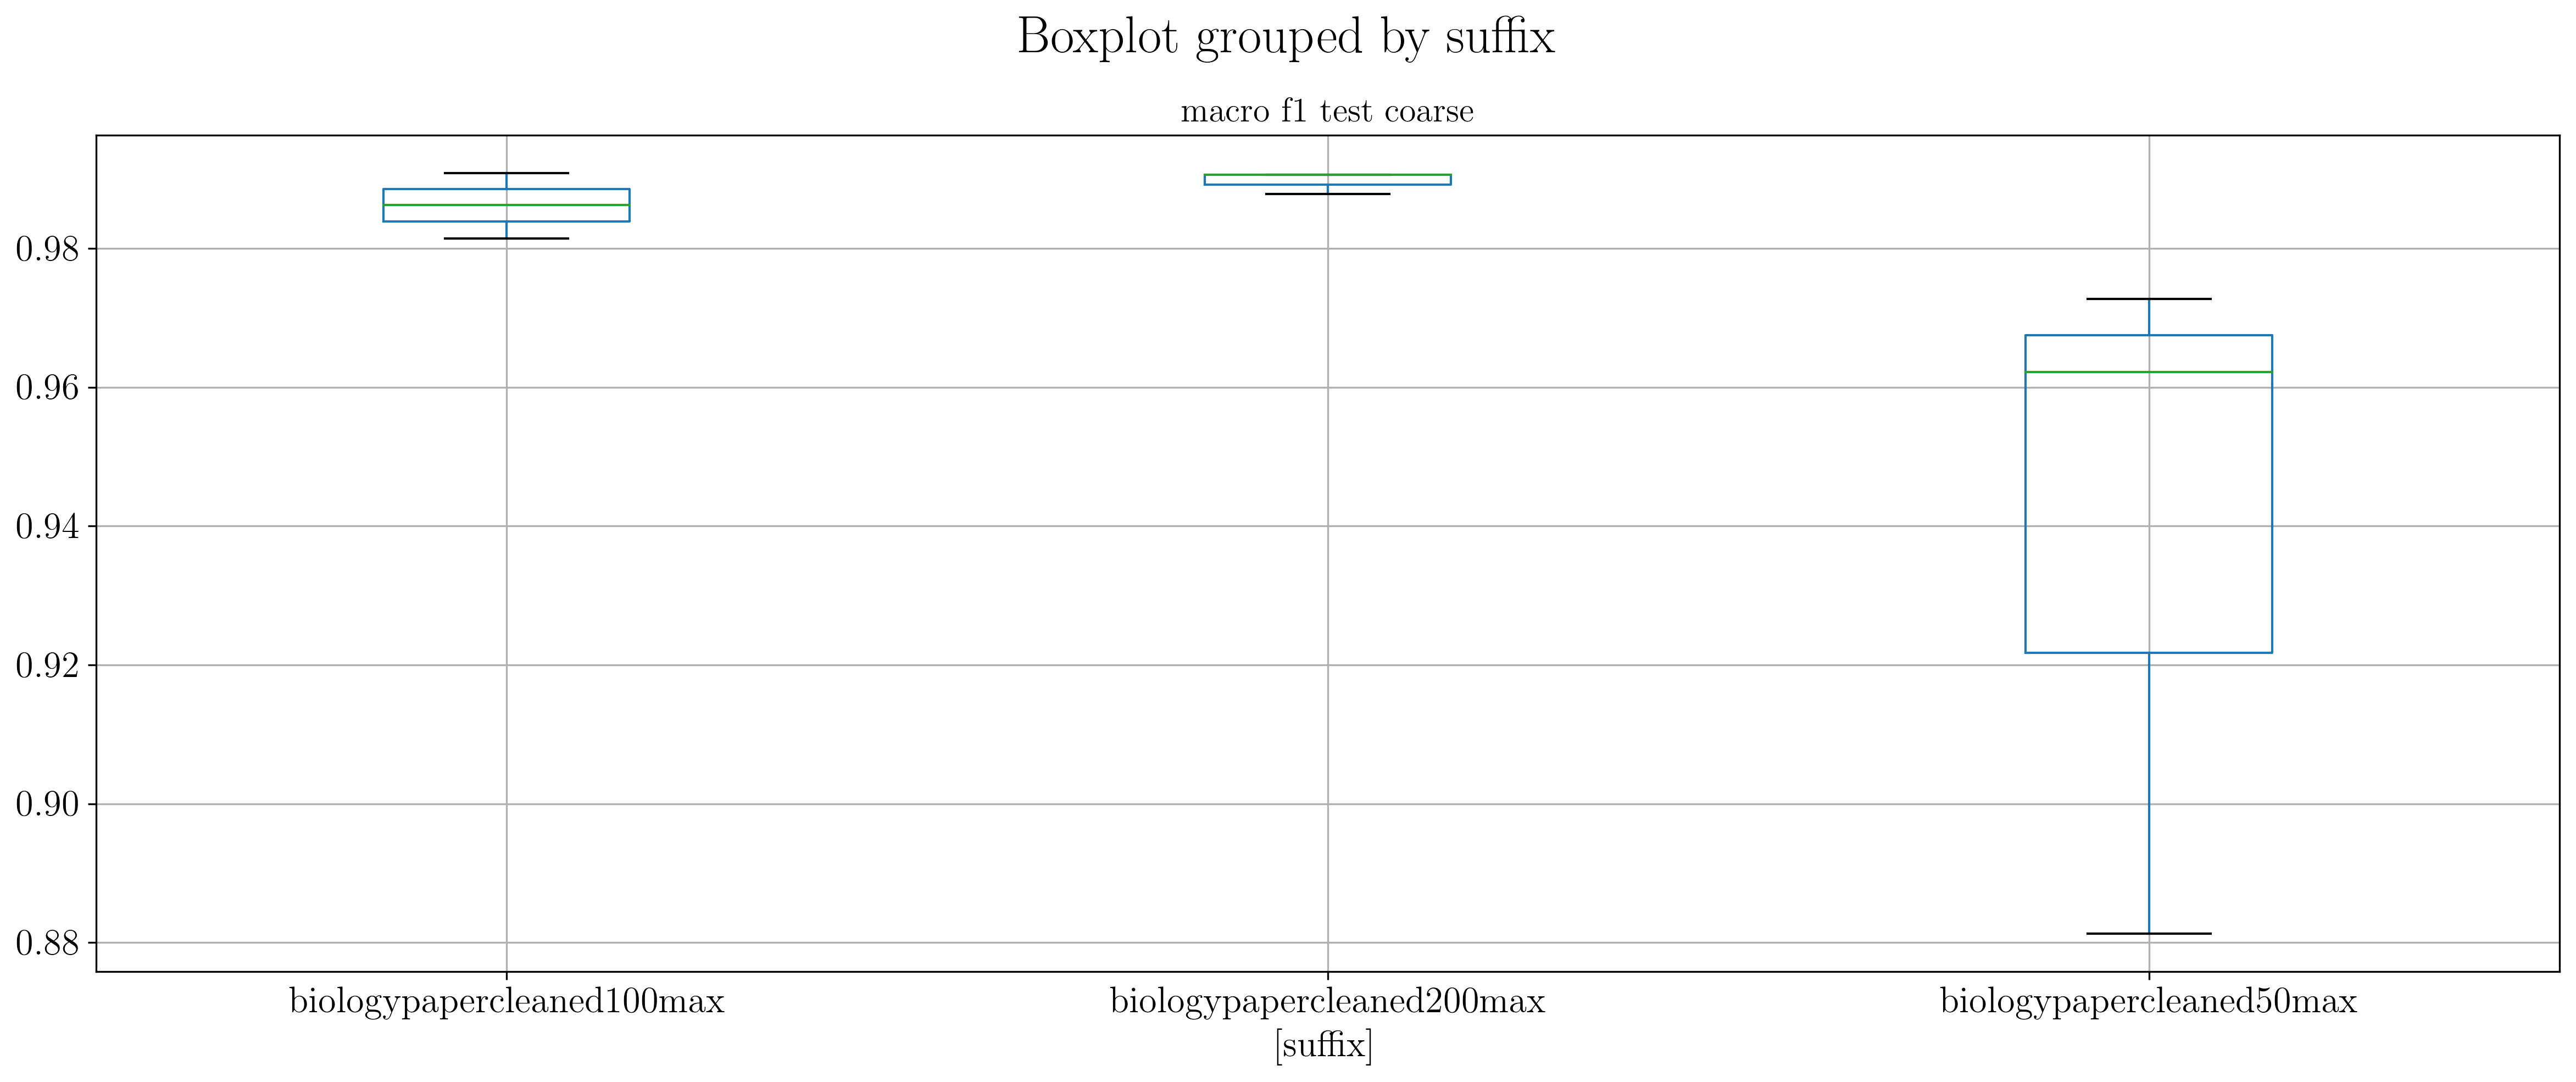

In [10]:
# ts.df = ts.df.rename(columns={"link_layer": "linkLayer"})
# ts.df.boxplot(column=['macro f1 test fine'], by=['suffix'], figsize=(16, 7))
ts.pandasBoxplot(['macro f1 test coarse'], ['suffix'])

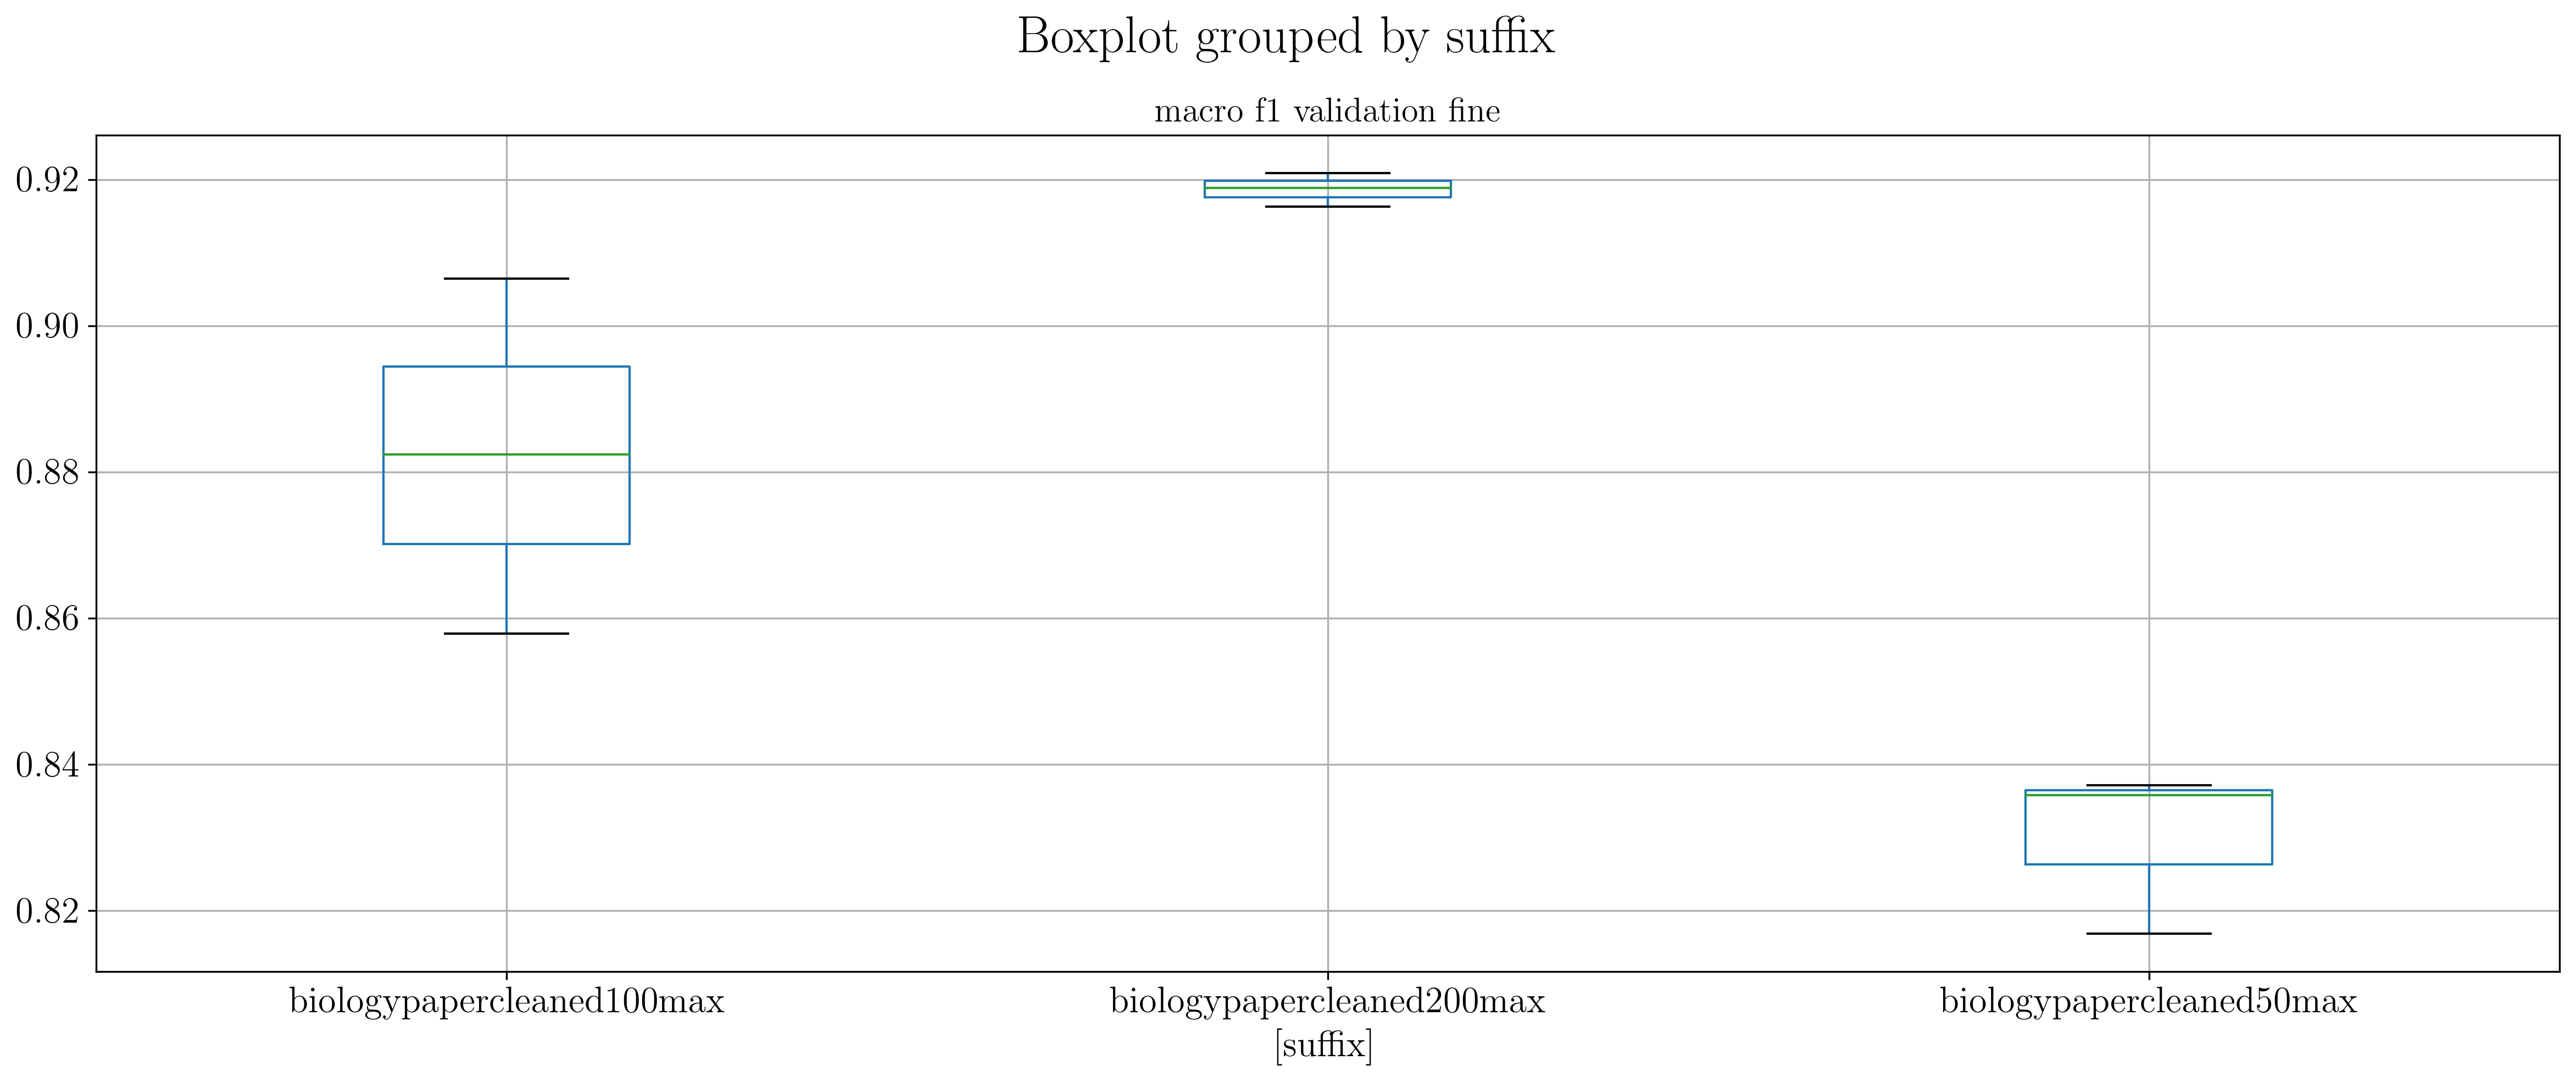

In [12]:
# ts.df.boxplot(column=['macro f1 validation fine'], by=['suffix'], figsize=(16, 7))
ts.pandasBoxplot(['macro f1 validation fine'], ['suffix'])


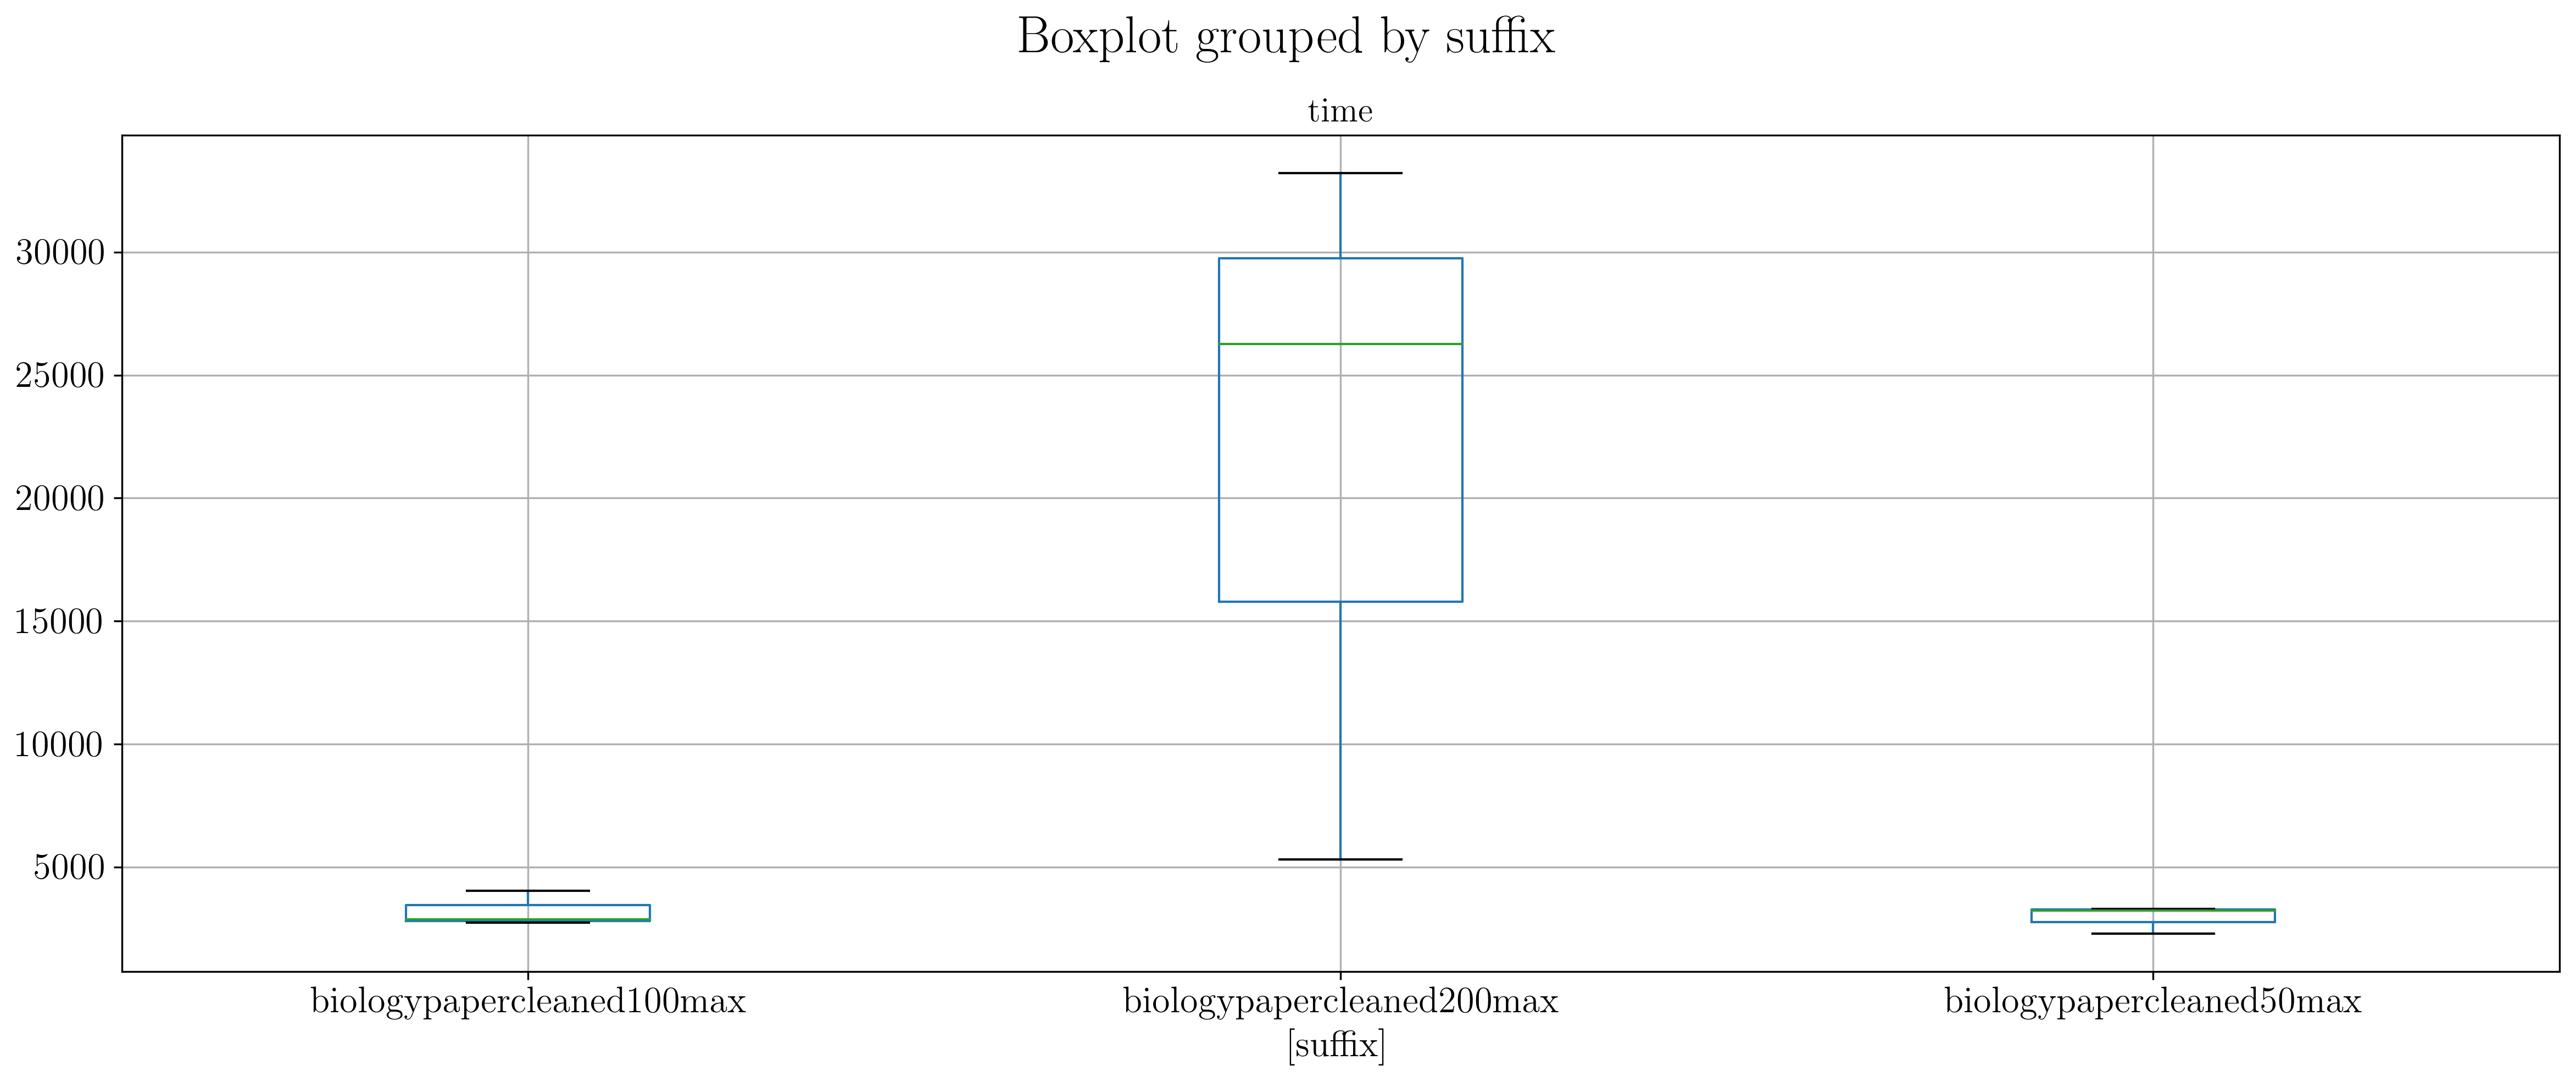

In [13]:
# ts.df.boxplot(column=['time'], by=['suffix'], figsize=(16, 7))
ts.pandasBoxplot(['time'], ['suffix'])


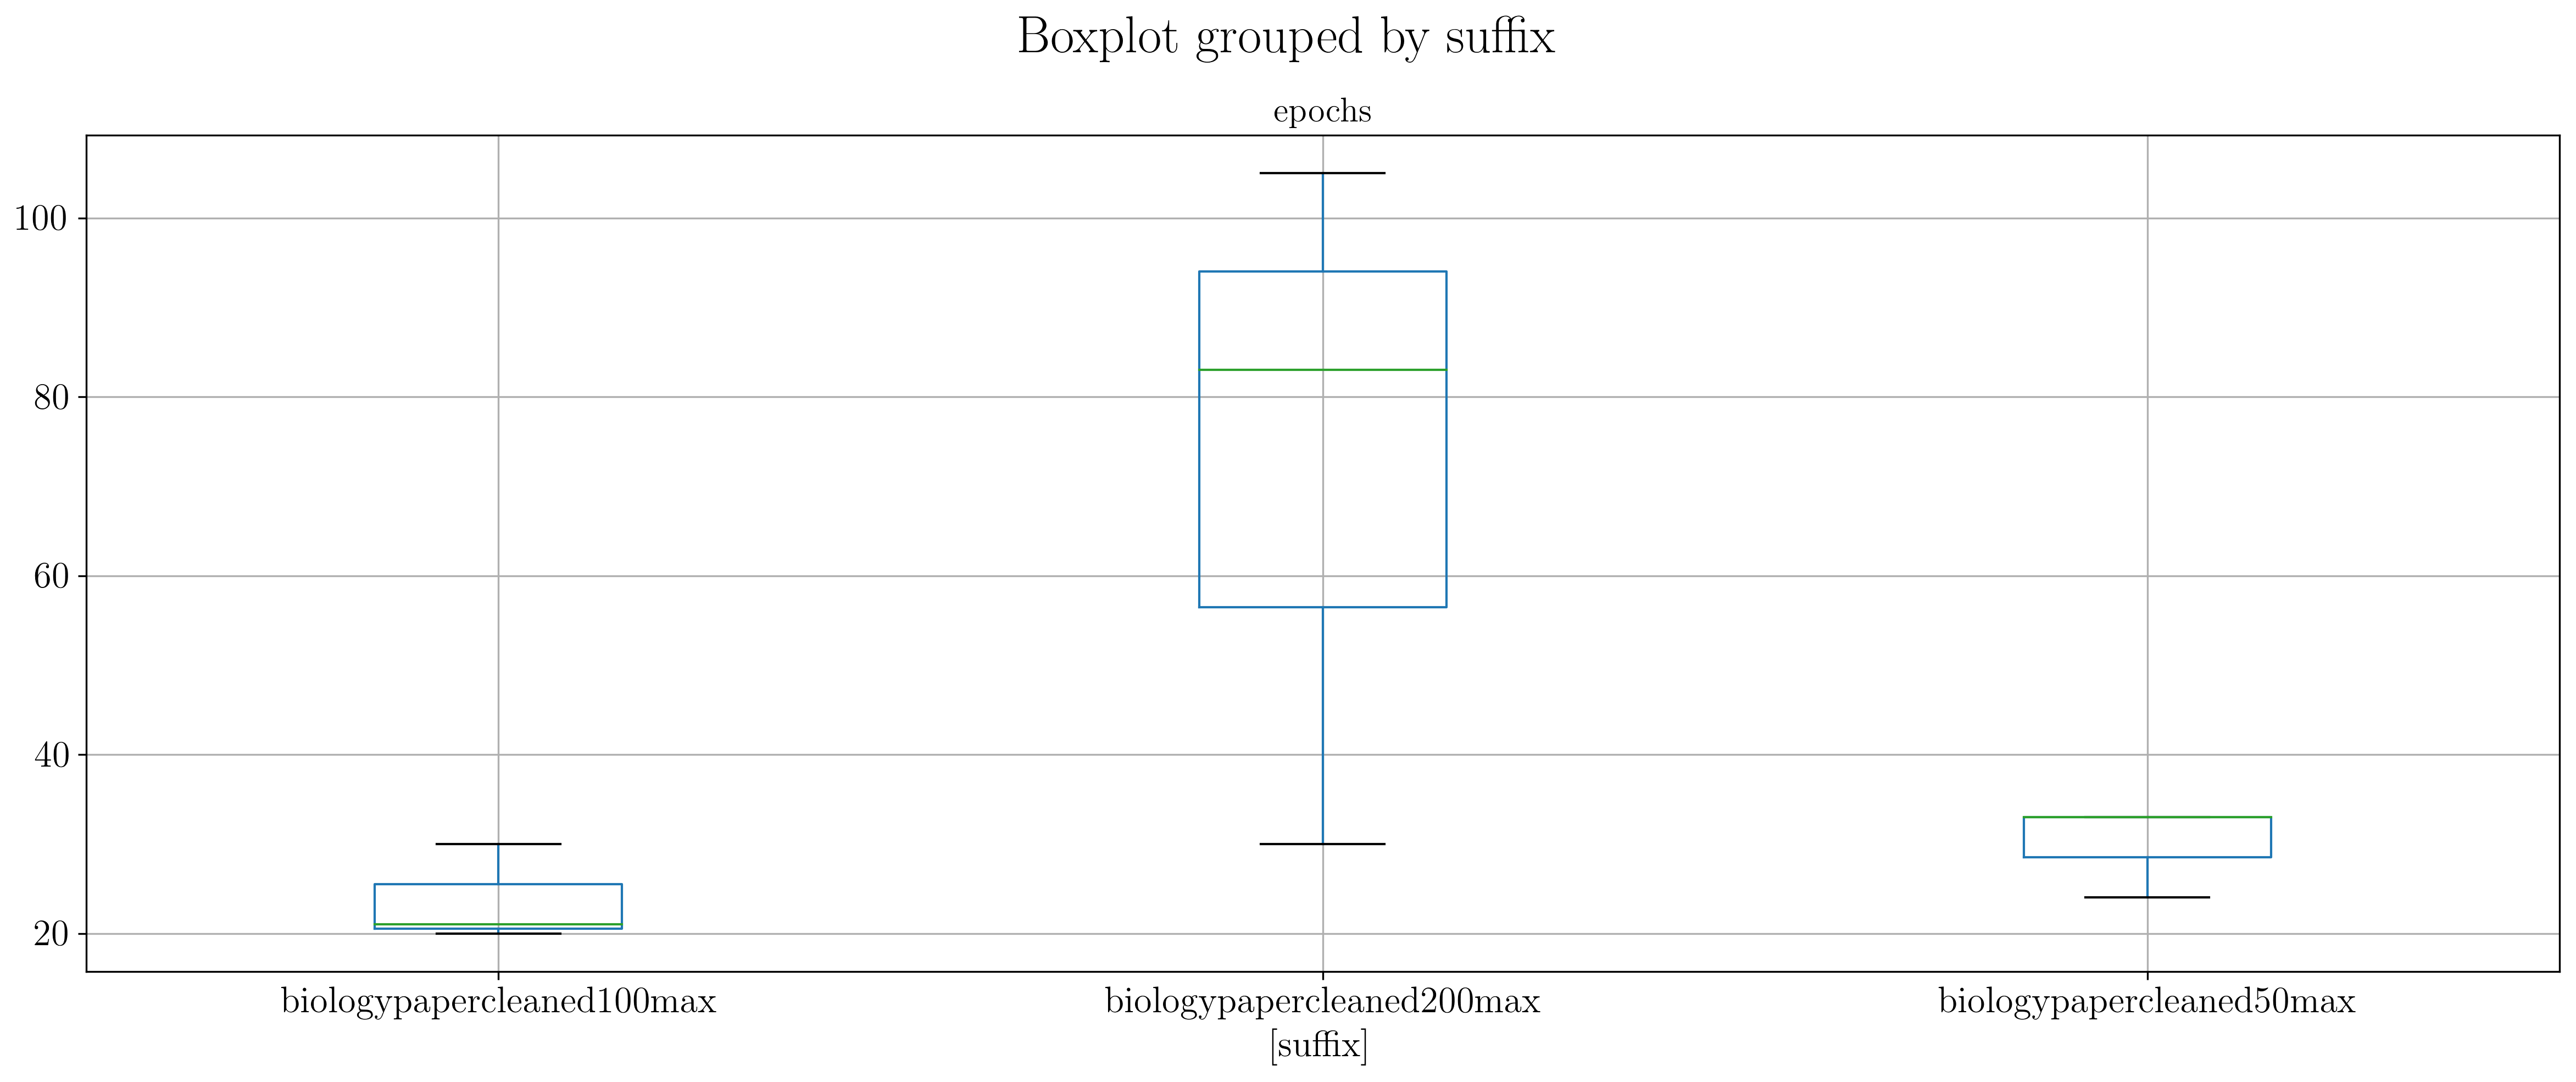

In [14]:
# ts.df.boxplot(column=['epochs'], by=['suffix'], figsize=(16, 7))
ts.pandasBoxplot(['epochs'], ['suffix'])
